<a href="https://colab.research.google.com/github/fishsizeproject/fish_size_model/blob/main/fish_size_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification with TensorFlow Lite Model Maker to estimate fish sizes

This notebook uses the [TensorFlow Lite Model Maker library](https://www.tensorflow.org/lite/guide/model_maker). TensorFlow Lite is a smaller version of the full TensorFlow libary. TensorFlow Lite is a machine learning solution specifically designed for mobile platforms. The library has a smaller number of integrated functions compared to TensorFlow but runs faster and is especially suitable for our aim here, which is to apply a classification method to estimate fish size class from images. 

In the past, new models haven been typically trained using the TensorFlow library and then converted into Lite models for implementation in smart devices. However, TensorFlow Lite has been improving rapidly and now it is possible to run many tasks using the Lite library directly, including training and optimising a new classification model. This is what we are going to do here.

Note, the model training step in this notebook might take quite a while to run depending on your dataset. 

## Prerequisites

To run this example, we first need to install several required packages, including Model Maker package that in GitHub [repo](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker).

In [ ]:
!sudo apt -y install libportaudio2


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 64.6 kB of archives.
After this operation, 215 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Fetched 64.6 kB in 0s (180 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


In [ ]:
!pip install -q tflite-model-maker

     |████████████████████████████████| 577 kB 4.3 MB/s 
     |████████████████████████████████| 3.4 MB 58.1 MB/s 
     |████████████████████████████████| 88 kB 3.5 MB/s 
     |████████████████████████████████| 77 kB 5.6 MB/s 
     |████████████████████████████████| 1.3 MB 33.3 MB/s 
     |████████████████████████████████| 10.9 MB 53.1 MB/s 
     |████████████████████████████████| 840 kB 56.2 MB/s 
     |████████████████████████████████| 60.8 MB 1.4 MB/s 
     |████████████████████████████████| 1.1 MB 50.7 MB/s 
     |████████████████████████████████| 238 kB 26.4 MB/s 
     |████████████████████████████████| 128 kB 58.9 MB/s 
     |████████████████████████████████| 25.3 MB 1.7 MB/s 
     |████████████████████████████████| 498.0 MB 9.8 kB/s 
     |████████████████████████████████| 352 kB 69.2 MB/s 
     |████████████████████████████████| 1.4 MB 60.3 MB/s 
     |████████████████████████████████| 462 kB 75.6 MB/s 
     |████████████████████████████████| 5.8 MB 65.9 MB/s 
     |███████████

Import the required packages.

In [ ]:
import os

import numpy as np

import tensorflow as tf
assert tf.__version__.startswith('2')

from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.image_classifier import DataLoader

import matplotlib.pyplot as plt

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


We will mount our example dataset from GitHub to access the dataset (we are actually cloning it here, into Google colab environment) (see [intro practice](https://colab.research.google.com/drive/1qhc8kgXAwM3k18zgweAsvwIjSG0Qm8lT#scrollTo=iAyufgu3eh0C) for mounting your dataset from your google drive if you are using your own images).

In [ ]:

import os

git_folder = "fishsizeproject/fish_size_model"
if os.path.exists(git_folder) == False:
   !git clone https://github.com/fishsizeproject/fish_size_model.git 

path_to_images = git_folder 

Cloning into 'fish_size_model'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (251/251), done.
remote: Compressing objects: 100% (239/239), done.
remote: Total 251 (delta 15), reused 230 (delta 7), pack-reused 0
Receiving objects: 100% (251/251), 10.78 MiB | 50.17 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [ ]:
ls

fish_size_model/  sample_data/


## Model training and testing



### Step 1: Load Input Data Specific

In you are bringing your own dataset, remember that the dataset should have the following directory structure - i.e. all photos for one class should be in a separate folder 


<pre>
<b>fish_photos</b>
|__ <b>class40</b>
    |______ 100080576_f52e8ee070_n.jpg
    |______ 14167534527_781ceb1b7a_n.jpg
    |______ ...
|__ <b>class50</b>
    |______ 10043234166_e6dd915111_n.jpg
    |______ 1426682852_e62169221f_m.jpg
    |______ ...

</pre>

We need to change our directory to the dataset directory.

In [ ]:
cd fish_size_model/images

/content/fish_size_model/images


In [ ]:
ls

class10/  class20/  class30/  class40/  class60/
class15/  class25/  class35/  class50/  class70/


Next, we will use the function `DataLoader` from library [pytorch](https://pytorch.org/docs/stable/data.html#:~:text=Data%20loader.,(collation)%20and%20memory%20pinning.) to load all images from a folder. For that we will use the `from_folder()` method. This method assumes that the all images from the same class are in the same folder and folder's name is the same as class name (e.g. "perch" or "trout" in our case). 
IMPORTANT: currently, only JPEG-encoded images and PNG-encoded images are supported by the `from_folder()` method.

In [ ]:
data = DataLoader.from_folder('./')


Ideally, the model performance should be evaluated on images that were not used to build or fine-tune the model, so that they provide an unbiased sense of model effectiveness.

As the name says, the “training” data set will be the images used to train the model while “test” and “validation” data set will be used to estimate model fit and performance.

A possible definition of these terms is:

**Training dataset**: images used to fit or train the model.

**Validation dataset**: images used to provide an unbiased evaluation of the model fit on the training dataset while tuning model hyperparameters. 

**Test dataset**: images used to provide an unbiased evaluation of the final model fit and its performance on the training dataset.

We will split our dataset into training data (80%), validation data (10%) and testing data (10%):

In [ ]:
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)

Let's have a look at 25 random images from our dataset folder, with their class names (or labels) included. Remember, labels are taken from the folder names.

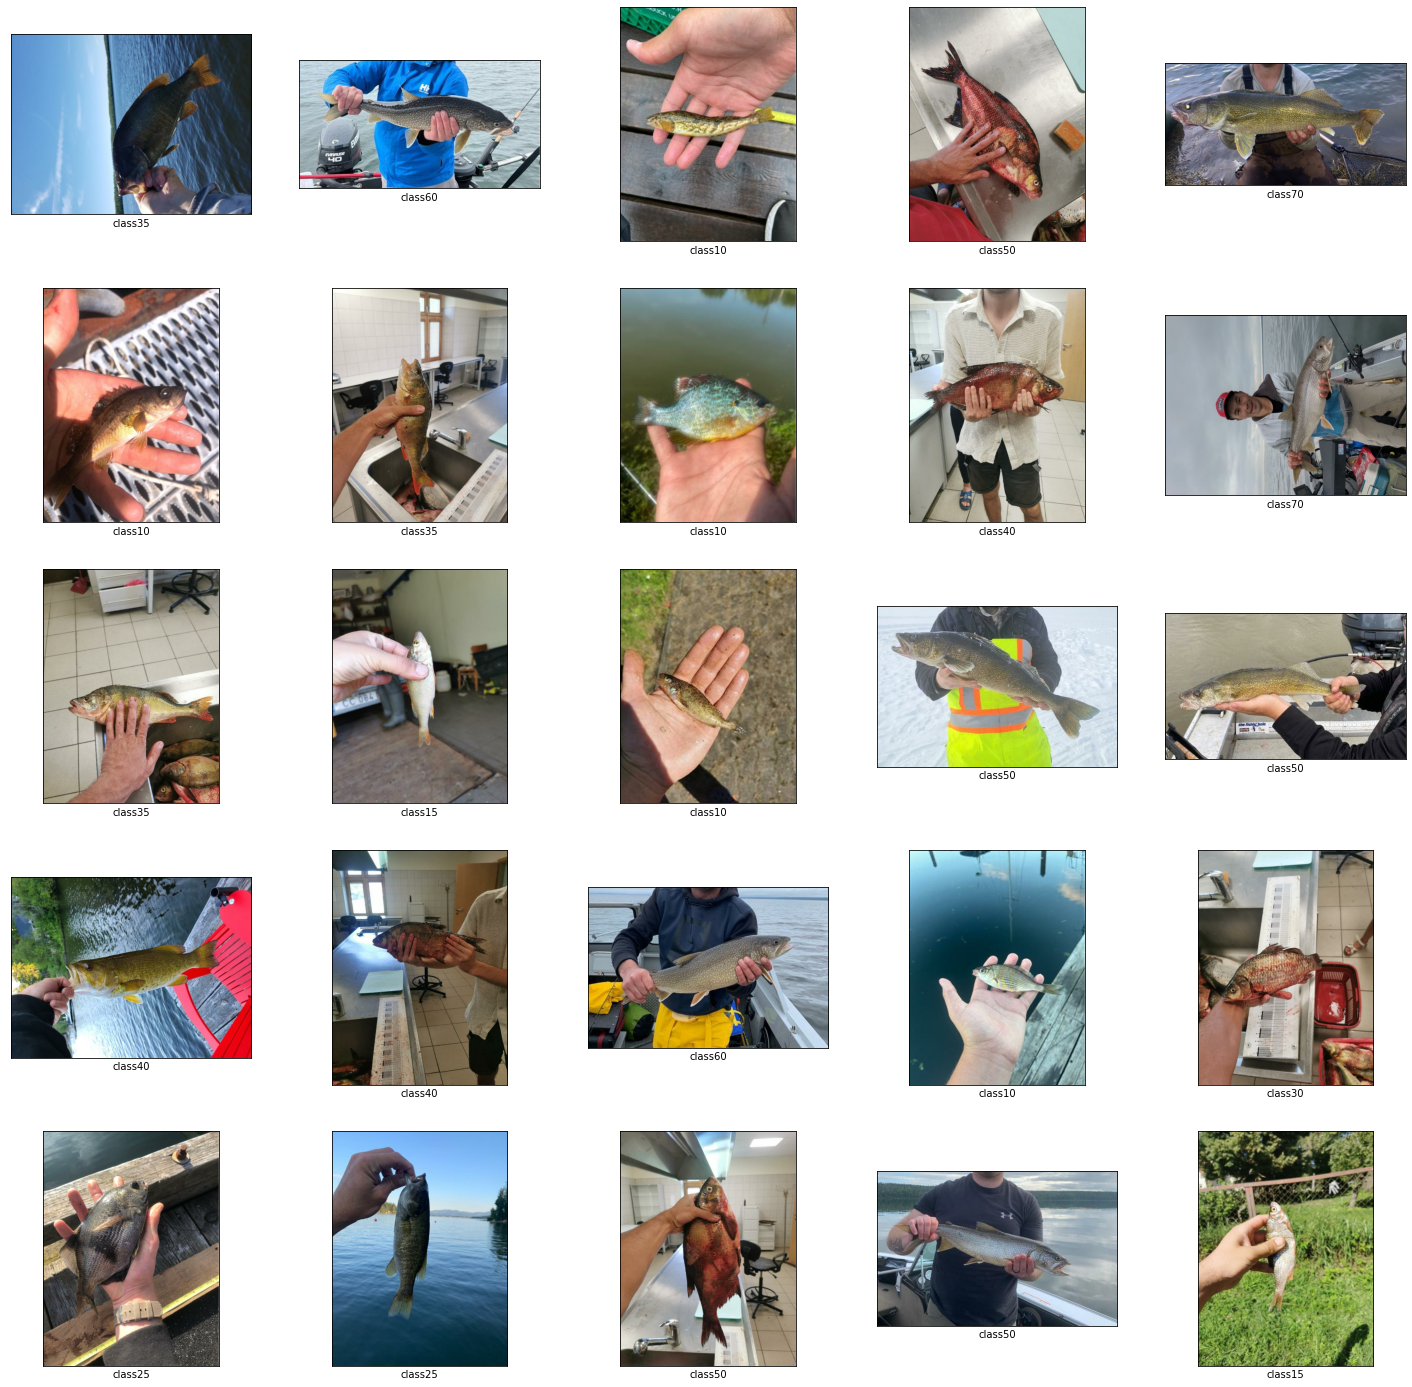

In [ ]:
plt.figure(figsize=(25,25))
for i, (image, label) in enumerate(data.gen_dataset().unbatch().take(25)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(data.index_to_label[label.numpy()])
plt.show()

### Step 2: Customize the TensorFlow Model


**Change the pretrained models**

Currently, Tensorflow Lite support several models already pretrained to recognise various classes from thousands of images. What we want to do is basically to add more classes into these pretrained models, so that in addition the "fish" class the model will now also have "perch", "trout" and "striped_bass" classes. Remember, the model does not know phylogeny, so it would not necessarily recognise that perch is within the fish class. It will just give us the name of the class with the highest score. 

TensorFlow Lite has several pretrained models, including EfficientNet-Lite, MobileNetV2, ResNet50. The library is flexible and new pre-trained models can be added to it with just a few lines of code (but we will not go into this here). 

To switch between different pretrained models you need to modify the parameter `model_spec` in the function below to one of the models: `mobilenet_v2`, `efficientnet_lite0` or `resnet_50`.

**Change the training hyperparameters**

There are many parameters that are used in the model training, and these parameters define various aspects of the process. We will not explore all of them here as this outside the scope of an introductory course. We will start with parameters like `epochs` and `batch_size` which can affect the model accuracy. Please watch the lecture associated with this notebook to learn more about these parameters. In case you do decide to explore the model optimisation process further, you can find the list of all model parameters [here](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/image_classifier/create). 

*   `epochs`: refers to one complete pass of the training dataset through the algorithm. More epochs could achieve better accuracy until it converges but training for too many epochs may lead to overfitting (see the lecture for more details on why overfitting is bad). 

*   `batch_size`: refers to the total number of images used for training in a single batch. For example if we have 1000 images in our training dataset we can divide it into batches of 500 then it will take 2 iterations to complete 1 epoch.

If you do not specify these parameters they will get the default values which you can check in [make_image_classifier_lib](https://github.com/tensorflow/hub/blob/02ab9b7d3455e99e97abecf43c5d598a5528e20c/tensorflow_hub/tools/make_image_classifier/make_image_classifier_lib.py#L54) from TensorFlow Hub library.

**Run the model**

Now we train the model. Depending on the size of your data and model parameters **this step can  take many hours to run**. For the example data set the runs took us 15-20 mins. But if you run the model many times during the same day the speed will slow down. This is because Google colab provides a limited amount of free GPU power for each user. Once that amount is used up for the day the calculations will slow down a lot or become impossibly slow. So if you decide to go ahead with building more complex models, you might need to look into more powerful GPU resources (on your computer, from Google or other cloud service providers). Check our publication [here](https://www.mdpi.com/2071-1050/14/21/14324#B23-sustainability-14-14324) where we review some of these services. 

In [ ]:
# model = image_classifier.create(train_data, validation_data=validation_data)
model = image_classifier.create(train_data, model_spec=model_spec.get('efficientnet_lite0'), validation_data=validation_data, batch_size=32, epochs=5)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2_1 (Hub  (None, 1280)             3413024   
 KerasLayerV1V2)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                12810     
                                                                 
Total params: 3,425,834
Trainable params: 12,810
Non-trainable params: 3,413,024
_________________________________________________________________
None
Epoch 1/5
5/5 [==============================] - 5s 634ms/step - loss: 2.4809 - accuracy: 0.1063 - val_loss: 2.3270 - val_accuracy: 0.1000
Epoch 2/5
5/5 [==============================] - 2s 490ms/step - loss: 2.2272 - accuracy: 0.2

Have a look at the detailed model structure.

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2_1 (Hub  (None, 1280)             3413024   
 KerasLayerV1V2)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                12810     
                                                                 
Total params: 3,425,834
Trainable params: 12,810
Non-trainable params: 3,413,024
_________________________________________________________________


### Step 3: Evaluate the Customized Model

Evaluate the result of the model, get the loss and accuracy of the model.

In [ ]:
loss, accuracy = model.evaluate(test_data)

1/1 [==============================] - 1s 616ms/step - loss: 1.8488 - accuracy: 0.2381


An overall **accuracy** of 25% is very poor but this is just an example dataset (with a very small number of images).

In supervised learning, the mathematical functions that measure how a machine learning model diverges from the truth is called **'loss functions'** or ‘cost functions’. In more general terms cost functions measure the amount of ‘disagreement’ between the obtained and ideal outputs.  

Just for reference, and this is a very rough generalisation, a loss value >1 means that the model is diverging too much from the truth and value of < 0.3 is great. Check, what is the loss function of the model you trained above.


In [ ]:
loss, accuracy = model.evaluate(validation_data)

1/1 [==============================] - 1s 522ms/step - loss: 1.9669 - accuracy: 0.3000


In [ ]:
loss, accuracy = model.evaluate(train_data)

6/6 [==============================] - 2s 293ms/step - loss: 1.5404 - accuracy: 0.6273


We could plot the predicted results in 100 test images. Predicted labels with red color are the wrong predicted results while others are correct.

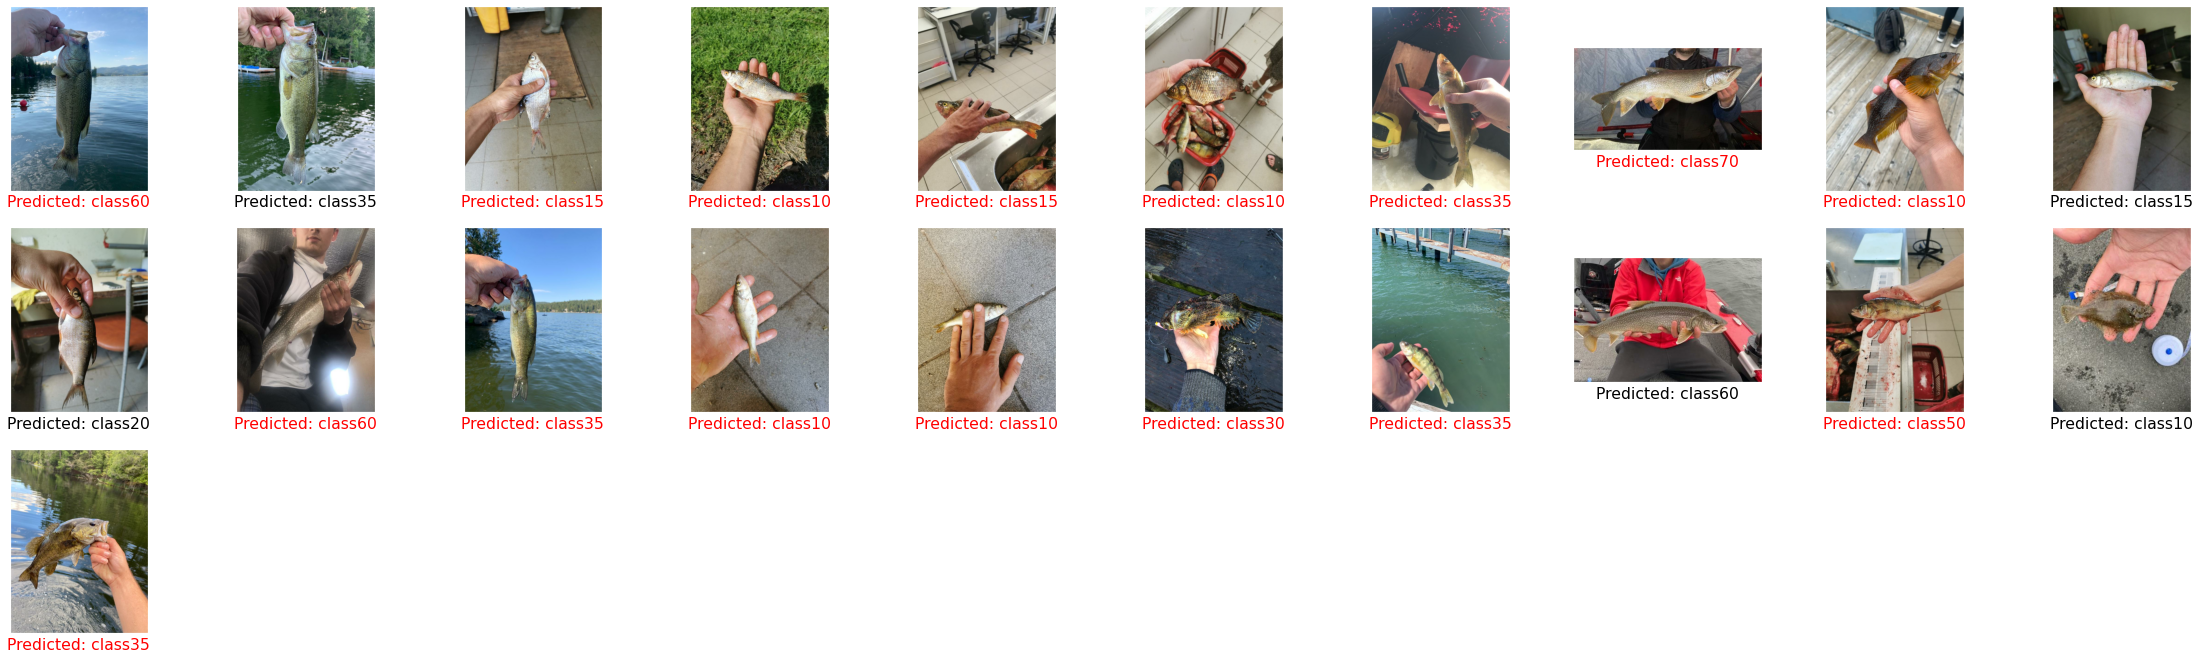

In [ ]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Then plot 100 test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(40, 40))
predicts = model.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.gen_dataset().unbatch()):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)

  predict_label = predicts[i][0][0]
  color = get_label_color(predict_label,
                          test_data.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
  plt.xlabel('Predicted: %s' % predict_label)
plt.show()

In [ ]:
# Import pandas library
import pandas as pd

# predicts = model.predict_top_k(test_data)
appended_data = []

for i, (image, label) in enumerate(test_data.gen_dataset().unbatch()):
  predicted_label = predicts[i][0][0]
  # expected_label = test_data.index_to_label[label.numpy()]
  # store DataFrame in list
  appended_data.append(predicted_label)
  # appended_data.append(expected_label)

df_predicted = pd.DataFrame(appended_data, columns = ['predicted'])


In [ ]:
df_predicted

,predicted
0,class60
1,class35
2,class15
3,class10
4,class15
5,class10
6,class35
7,class70
8,class10
9,class15


In [ ]:
# predicts = model.predict_top_k(test_data)
appended_data = []

for i, (image, label) in enumerate(test_data.gen_dataset().unbatch()):
  # predicted_label = predicts[i][0][0]
  expected_label = test_data.index_to_label[label.numpy()]
  # store DataFrame in list
  # appended_data.append(predicted_label)
  appended_data.append(expected_label)

df_expected = pd.DataFrame(appended_data, columns = ['expected'])
df_expected

,expected
0,class35
1,class35
2,class20
3,class15
4,class30
5,class25
6,class30
7,class60
8,class25
9,class15


In [ ]:
df_confusion = pd.concat([df_predicted, df_expected], axis=1)
df_confusion

,predicted,expected
0,class60,class35
1,class35,class35
2,class15,class20
3,class10,class15
4,class15,class30
5,class10,class25
6,class35,class30
7,class70,class60
8,class10,class25
9,class15,class15


In [ ]:
df_confusion.to_csv("../../df_confusion_example_dataset.csv")

In [ ]:
predicts[0:5]

[[('class60', 0.21822943)],
 [('class35', 0.1769353)],
 [('class15', 0.35896024)],
 [('class10', 0.44290483)],
 [('class15', 0.30018052)]]

In [ ]:
df_prob_predicts = pd.DataFrame(predicts)
df_prob_predicts.to_csv("../../df_prob_predicts_example_dataset.csv")

In [ ]:
df_prob_predicts.shape

(21, 1)

If the accuracy doesn't meet the app requirement, one could refer to [Advanced Usage](#scrollTo=zNDBP2qA54aK) to explore alternatives such as changing to a larger model, adjusting re-training parameters etc.

### Step 4: Confusion matrix

In [ ]:
import pandas as pd
df_confusion = pd.read_csv("../../df_confusion_example_dataset.csv", index_col=False)
df_confusion.head(5)

,Unnamed: 0,predicted,expected
0,0,class60,class35
1,1,class35,class35
2,2,class15,class20
3,3,class10,class15
4,4,class15,class30


In [ ]:
df_confusion.shape

(21, 3)

In [ ]:
df1 = df_confusion['predicted'].value_counts().rename_axis('predicted').reset_index(name='N. of predicted')
df1

,predicted,N. of predicted
0,class10,6
1,class35,5
2,class60,3
3,class15,3
4,class70,1
5,class20,1
6,class30,1
7,class50,1


In [ ]:
df2 = df_confusion['expected'].value_counts().rename_axis('expected').reset_index(name='N. of expected')
df2

,expected,N. of expected
0,class15,5
1,class20,4
2,class30,3
3,class25,3
4,class35,2
5,class60,2
6,class50,1
7,class10,1


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(df_confusion["expected"], df_confusion["predicted"])
confusion_matrix

array([[1, 0, 0, 0, 0, 0, 0, 0, 0],
       [3, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 0, 1, 0, 1, 0, 0],
       [2, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
confusion_matrix.sum(axis=0)

array([6, 3, 1, 0, 1, 5, 1, 3, 1])

In [ ]:
confusion_matrix.sum()

21

In [ ]:
confusion_normalized = confusion_matrix.astype("float") / confusion_matrix.sum(axis=1)[:,None]
confusion_normalized

<ipython-input-79-1cb8b3c0262b>:1: RuntimeWarning: invalid value encountered in true_divide
  confusion_normalized = confusion_matrix.astype("float") / confusion_matrix.sum(axis=1)[:,None]


array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.6       , 0.2       , 0.        , 0.        , 0.        ,
        0.2       , 0.        , 0.        , 0.        ],
       [0.        , 0.25      , 0.25      , 0.        , 0.25      ,
        0.        , 0.25      , 0.        , 0.        ],
       [0.66666667, 0.        , 0.        , 0.        , 0.        ,
        0.33333333, 0.        , 0.        , 0.        ],
       [0.        , 0.33333333, 0.        , 0.        , 0.        ,
        0.66666667, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.5       , 0.        , 0.5       , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.5       , 0.5       ],


Text(0.5, 111.09999999999997, 'Predicted label')

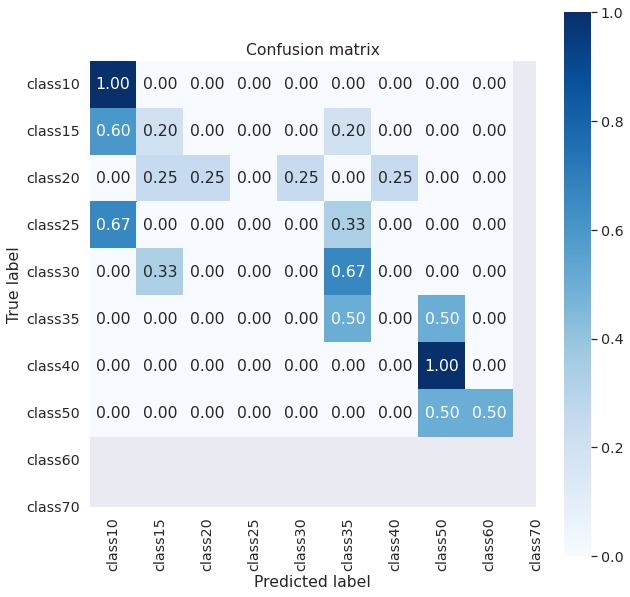

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

from matplotlib import pyplot
pyplot.figure(figsize=(10, 10)) # width and height in inches

axis_labels = ["class10", "class15","class20", "class25", "class30", "class35", "class40", "class50", "class60", "class70"]
sns.set(font_scale=1.3)
ax = sns.heatmap(confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels, 
                 cmap='Blues', annot=True, fmt='.2f', square=True)
plt.title("Confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")

### Step 5: Export to TensorFlow Lite Model

Convert the trained model to TensorFlow Lite model format with [metadata](https://www.tensorflow.org/lite/convert/metadata) so that you can later use it. The default TFLite filename is `model.tflite` (if no argument `tflite_filename=` is added).



In [ ]:
model.export(export_dir='../../', tflite_filename='model_efficientnet.tflite')

The allowed export formats can be one or a list of the following:

*   `ExportFormat.TFLITE`
*   `ExportFormat.LABEL`
*   `ExportFormat.SAVED_MODEL`

By default, it just exports TensorFlow Lite model with metadata. You can also selectively export different files. For instance, exporting only the label file as follows:

In [ ]:
# model.export(export_dir='.', export_format=ExportFormat.LABEL)

# Acknowledgements

The study has been supported by the European Regional Development Fund (project No 01.2.2-LMT-K-718-02-0006) under grant agreement with the Research Council of Lithuania (LMTLT)